#### 功能说明：
+ 对原始简笔画分割数据进行处理，生成用于训练的数据
+ txt文件中一行为一个图片的数据，数据以空格分割，第一个元素是图片路径，后面元素依次是每一个物体的xmin，ymin，xmax和ymax

#### 原数据格式要求：
+ 数据存放在doodles/{动物名称}指向的文件夹中，该文件夹中的文件包括：
    + 224x224的原图，名称为{uuid}.png
    + 224x224的分割图，名称为{uuid}.{n}.png，其中n为分割部署的序号，从0开始
    + {uuid}.json，为骨骼标注结果，在分割任务中应忽略
    + 224x224的骨骼标注图，是给人看的，机器应忽略

In [43]:
import os
from scipy import misc
import json
import shutil
from matplotlib import pyplot as plt
import numpy as np
import numpy.ma as ma
import uuid
import random
%matplotlib inline

#### 可配置的参数：
+ 动物名称，需要和原始文件夹对应，准备好的数据也将存放在data\_{动物名称}文件夹中

In [44]:
# Set directories 
animal = "goose"
raw_data_dirs = ['doodles/goose_20170801', 'doodles/goose_20170817']
data_dir_root = 'data_' + animal

In [45]:
# Build data directory
if os.path.isdir(data_dir_root):
    shutil.rmtree(data_dir_root)
os.mkdir(data_dir_root)

img_dir = os.path.join(data_dir_root, 'images')
label_dir = os.path.join(data_dir_root, 'labels')
label_img_dir = os.path.join(data_dir_root, 'label_images')
os.mkdir(img_dir)
os.mkdir(label_dir)
os.mkdir(label_img_dir)

In [46]:
records = []
for raw_data_dir in raw_data_dirs:
    # Get number of objects
    conf_path = os.path.join(raw_data_dir, 'conf.json')
    with open(conf_path) as f:
        conf = json.loads(f.read())
    label_num = conf['obj_num']
    
    img_names = os.listdir(raw_data_dir)
    for img_name in img_names:
        # only fetch the original image
        if "mask" in img_name or "json" in img_name or "result" in img_name:
            continue
        # give a new uuid4 name in case of duplicate file name
        new_img_name = str(uuid.uuid4()) + '.png'
        img_path = os.path.join(raw_data_dir, img_name)
        img = misc.imread(img_path)
        label_data = np.ones(img.shape[0:2], dtype='byte')
        for label_idx in range(label_num):
            mask_path = img_path.replace("png", "mask." + str(label_idx) + ".png")
            cur_label_img = misc.imread(mask_path, mode='L')
            cur_label_img = np.minimum(cur_label_img, np.ones(cur_label_img.shape))
            label_data_mx = ma.masked_array(label_data, mask=cur_label_img)
            # label 0: don't care
            # label 1: background
            # label 2 and above: objects
            # Thus, the object label should start from 2
            ma.set_fill_value(label_data_mx, label_idx + 2)
            label_data = label_data_mx.filled()
      
        # get target path
        new_img_path = os.path.join(img_dir, new_img_name)
        label_img_path = os.path.join(label_img_dir, new_img_name)
        label_path = os.path.join(label_dir, new_img_name).replace('.png', '.dat')
        
        # save results to files
        misc.imsave(new_img_path, img)
        misc.imsave(label_img_path, label_data)
        label_file = open(label_path, "wb")
        byte_data = bytearray(label_data)
        label_file.write(byte_data)
        label_file.close()
        
        records.append(new_img_path + "\n")
print('Totally found: ', len(records))

Totally found:  202


In [47]:
# split into training set and test set
random.shuffle(records)
test_ratio = 0.1
total_num = len(records)
test_num = int(test_ratio * total_num)
train_num = total_num - test_num
train_records = records[0:train_num]
test_records = records[train_num:]

In [48]:
# save to text file
all_out_file = open(animal + "_all.txt", "w")
for record in records:
    all_out_file.write(record)
all_out_file.close()

train_out_file = open(animal + "_train.txt", "w")
for record in train_records:
    train_out_file.write(record)
train_out_file.close()

test_out_file = open(animal + "_test.txt", "w")
for record in test_records:
    test_out_file.write(record)
test_out_file.close()

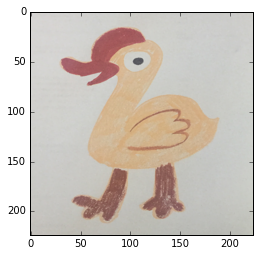

In [49]:
plt.imshow(img)

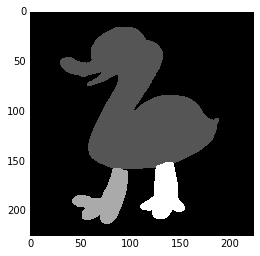

In [50]:
plt.imshow(label_data, cmap='gray')